# **Quick Quality Check**

Our **objective** here is to begin with intitial data validation for Reddit posts from multiple subreddits. Quick overview before full EDA and cleaning.

---

## Table of Contents

- [1. Data Overview](#1-data-overview)
- [2. Subreddit Distribution](#2-subreddit-distribution)
- [3. Text Content Analysis](#3-text-content-analysis)
- [4. Quality Check Summary](#4-quality-check-summary)

[Next: Cleaning & Merge →](02_clean_merge.ipynb)

----

In [33]:
# remove -q to see output
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [34]:
# Import libraries
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import List, Dict, Any
import warnings
from typing import List, Dict, Any
warnings.filterwarnings('ignore')


ARTIFACTS = Path("../artifacts/images/"); ARTIFACTS.mkdir(parents=True, exist_ok=True)               # Output figures

In [35]:
# Helper functions

def load_jsonl(path: Path) -> List[Dict[str, Any]]:
    """Load raw data from JSONL file for quality check."""
    rows: List[Dict[str, Any]] = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows


def analyze_dataframe(df: pd.DataFrame, name: str = "DATASET") -> None:
    """Analyze dataframe with formatted output showing shape, columns, types, and missing values."""
    print(f"\n{'='*50}")
    print(f" {name} ANALYSIS")
    print(f"{'='*50}")

    # Basic info
    print(f" Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

    # Column list
    print(f"\n Columns ({len(df.columns)}):")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i:2d}. {col}")

    # Data types summary
    print(f"\n Data Types Summary:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  • {dtype}: {count} columns")

    # Missing values analysis
    print(f"\n Missing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100)

    has_missing = missing[missing > 0]
    if len(has_missing) == 0:
        print("   No missing values found!")
    else:
        print(f"   {len(has_missing)} columns have missing values:")
        for col in has_missing.index:
            count = missing[col]
            pct = missing_pct[col]
            print(f"     • {col:<25}: {count:>6,} ({pct:>5.1f}%)")

    print(f"{'='*50}")


def analyze_subreddit_distribution(posts_df: pd.DataFrame) -> None:
    """Analyze and visualize subreddit distribution with bar chart and pie chart."""
    subreddit_counts = posts_df['subreddit'].value_counts()
    subreddit_pct = (subreddit_counts / len(posts_df) * 100)

    # Print formatted distribution
    print(f"\n{'='*50}")
    print(f" SUBREDDIT DISTRIBUTION")
    print(f"{'='*50}")
    print(f" Total posts across {len(subreddit_counts)} subreddits:")

    for subreddit, count in subreddit_counts.items():
        pct = subreddit_pct[subreddit]
        bar_length = int(pct / 2)
        bar = "█" * bar_length + "░" * (20 - bar_length)
        print(f"  {subreddit:<20} │{bar}│ {count:>6,} ({pct:>5.1f}%)")

    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar plot
    subreddit_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='navy')
    ax1.set_title('Posts per Subreddit', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Subreddit')
    ax1.set_ylabel('Number of Posts')
    ax1.tick_params(axis='x', rotation=45)

    # Pie chart
    colors = plt.cm.Set3(np.linspace(0, 1, len(subreddit_counts)))
    wedges, texts, autotexts = ax2.pie(subreddit_counts.values,
                                       labels=subreddit_counts.index,
                                       autopct='%1.1f%%',
                                       colors=colors,
                                       startangle=90)
    ax2.set_title('Subreddit Distribution', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()
    print(f"{'='*50}")


def analyze_text_lengths(posts_df: pd.DataFrame) -> None:
    """Analyze text length distributions with histograms and boxplots by subreddit."""
    # Create fulltext column if missing
    CANDIDATE_TEXT_COLS = ["fulltext", "processed_full_text", "cleaned_text", "selftext", "text"]

    if "fulltext" not in posts_df.columns:
        if ("title" in posts_df.columns) or ("selftext" in posts_df.columns):
            posts_df["fulltext"] = (
                posts_df.get("title", "").fillna("").astype(str) + " " +
                posts_df.get("selftext", "").fillna("").astype(str)
            ).str.strip()
        else:
            src = next((c for c in CANDIDATE_TEXT_COLS if c in posts_df.columns), None)
            posts_df["fulltext"] = posts_df[src].fillna("").astype(str) if src else ""

    # Calculate lengths safely
    def safe_len(x):
        if pd.isna(x):
            return 0
        if isinstance(x, list):
            return len(" ".join(str(t) for t in x))
        return len(str(x))

    for base in ["title", "selftext", "fulltext"]:
        if base in posts_df.columns:
            posts_df[f"{base}_len"] = posts_df[base].apply(safe_len)

    # Print statistics
    print("Text Length Statistics:")
    for base in ["title", "selftext", "fulltext"]:
        col = f"{base}_len"
        if col in posts_df.columns:
            print(f"{base.capitalize()} length - Mean: {posts_df[col].mean():.1f}, Median: {posts_df[col].median():.1f}")

    # Histograms for each text type
    length_cols = [c for c in ["title_len", "selftext_len", "fulltext_len"] if c in posts_df.columns]

    if length_cols:
        fig, axes = plt.subplots(1, len(length_cols), figsize=(6*len(length_cols), 5))
        if len(length_cols) == 1:
            axes = [axes]

        for i, col in enumerate(length_cols):
            axes[i].hist(posts_df[col], bins=50, edgecolor="black", alpha=0.7)
            axes[i].set_title(col.replace("_", " ").title())
            axes[i].set_xlabel("Character Count")
            axes[i].set_ylabel("Frequency")

        plt.tight_layout()
        plt.show()

    # Boxplot by subreddit
    if ("subreddit" in posts_df.columns) and ("fulltext_len" in posts_df.columns):
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=posts_df, x="subreddit", y="fulltext_len")
        plt.title("Full Text Length by Subreddit")
        plt.xlabel("Subreddit")
        plt.ylabel("Character Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


def print_linkage_analysis(posts_df: pd.DataFrame, comments_df: pd.DataFrame) -> None:
    """Print linkage statistics between posts and comments."""
    linked_posts = comments_df['link_id'].str.replace('t3_', '').nunique()
    print(f"\n{'='*50}")
    print(f" LINKAGE ANALYSIS")
    print(f"{'='*50}")
    print(f" Posts with comments: {linked_posts:,} / {len(posts_df):,} ({linked_posts/len(posts_df)*100:.1f}%)")
    print(f" Average comments per post: {len(comments_df) / len(posts_df):.1f}")
    print(f"{'='*50}")


def setup_pandas_display() -> None:
    """Configure pandas display settings for better readability."""
    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_columns', 20)
    pd.set_option('display.width', 120)
    pd.set_option('display.precision', 2)
    pd.set_option('display.float_format', '{:.2f}'.format)

----

## **1. Data Overview**

**Dataset:** Reddit posts from multiple subreddits.

Subreddits: r/unpopularopinion, r/Anxiety, r/economy, r/TrueOffMyChest, r/OpenAI, r/mentalhealth, r/GetMotivated, r/HealthAnxiety


**Files**
- Posts: `submission.jsonl`
- Comments: `comments_topk.jsonl` (top 3 per post)


In [36]:
# Load and analyze posts data
post_records = load_jsonl(Path("../data/raw/submission.jsonl"))
posts_df = pd.DataFrame(post_records)
analyze_dataframe(posts_df, "POSTS")

# Load and analyze comments data
comment_records = load_jsonl(Path("../data/raw/comments_topk.jsonl"))
comments_df = pd.DataFrame(comment_records)
analyze_dataframe(comments_df, "COMMENTS")

# Analyze relationship between posts and comments
print_linkage_analysis(posts_df, comments_df)


 POSTS ANALYSIS
 Dataset Shape: 6,503 rows × 10 columns

 Columns (10):
   1. post_id
   2. subreddit
   3. created_utc
   4. title
   5. selftext
   6. score
   7. num_comments
   8. upvote_ratio
   9. over_18
  10. removed_by_category

 Data Types Summary:
  • object: 5 columns
  • float64: 2 columns
  • int64: 2 columns
  • bool: 1 columns

 Missing Values:
   1 columns have missing values:
     • removed_by_category      :  6,503 (100.0%)

 COMMENTS ANALYSIS
 Dataset Shape: 13,422 rows × 7 columns

 Columns (7):
   1. comment_id
   2. link_id
   3. parent_id
   4. body
   5. created_utc
   6. score
   7. depth

 Data Types Summary:
  • object: 4 columns
  • int64: 2 columns
  • float64: 1 columns

 Missing Values:
   No missing values found!

 LINKAGE ANALYSIS
 Posts with comments: 5,183 / 6,503 (79.7%)
 Average comments per post: 2.1


---

## **2. Subreddit Distribution**
Check post counts and balance across subreddits to identify any collection biases.


 SUBREDDIT DISTRIBUTION
 Total posts across 8 subreddits:
  unpopularopinion     │███████░░░░░░░░░░░░░│    980 ( 15.1%)
  Anxiety              │███████░░░░░░░░░░░░░│    971 ( 14.9%)
  economy              │███████░░░░░░░░░░░░░│    965 ( 14.8%)
  TrueOffMyChest       │███████░░░░░░░░░░░░░│    915 ( 14.1%)
  OpenAI               │██████░░░░░░░░░░░░░░│    814 ( 12.5%)
  mentalhealth         │██████░░░░░░░░░░░░░░│    790 ( 12.1%)
  GetMotivated         │█████░░░░░░░░░░░░░░░│    768 ( 11.8%)
  HealthAnxiety        │██░░░░░░░░░░░░░░░░░░│    300 (  4.6%)


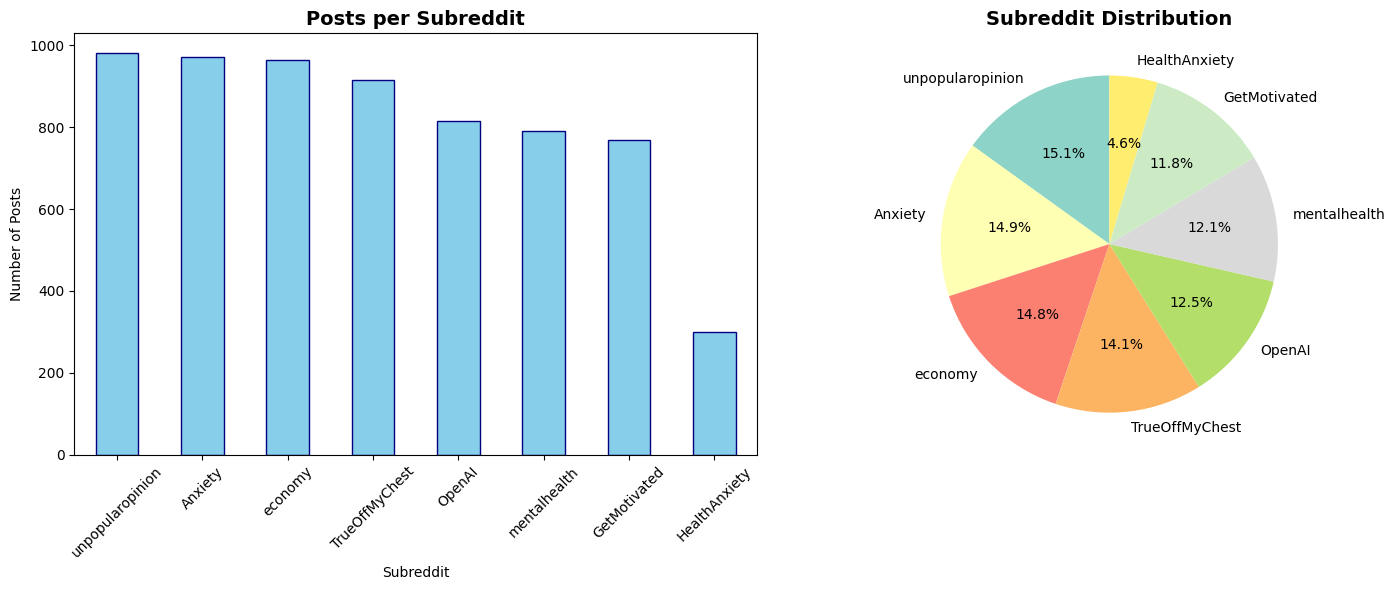

<Figure size 640x480 with 0 Axes>

In [37]:
# Configure pandas display settings for better output
setup_pandas_display()

# Visualize distribution of posts across subreddits
analyze_subreddit_distribution(posts_df)

# save the plotsn with artifacts defined above
plt.savefig(ARTIFACTS / "../images/analyze_subreddit_distribution.png", dpi=150)
plt.show()

----

## **3. Text Content Analysis**

Combines title and body text into unified `fulltext` field. Analyzes length distributions to detect outliers, empty content, and subreddit-specific patterns that could affect downstream analysis.

Text Length Statistics:
Title length - Mean: 58.2, Median: 51.0
Selftext length - Mean: 892.6, Median: 557.0
Fulltext length - Mean: 951.3, Median: 612.0


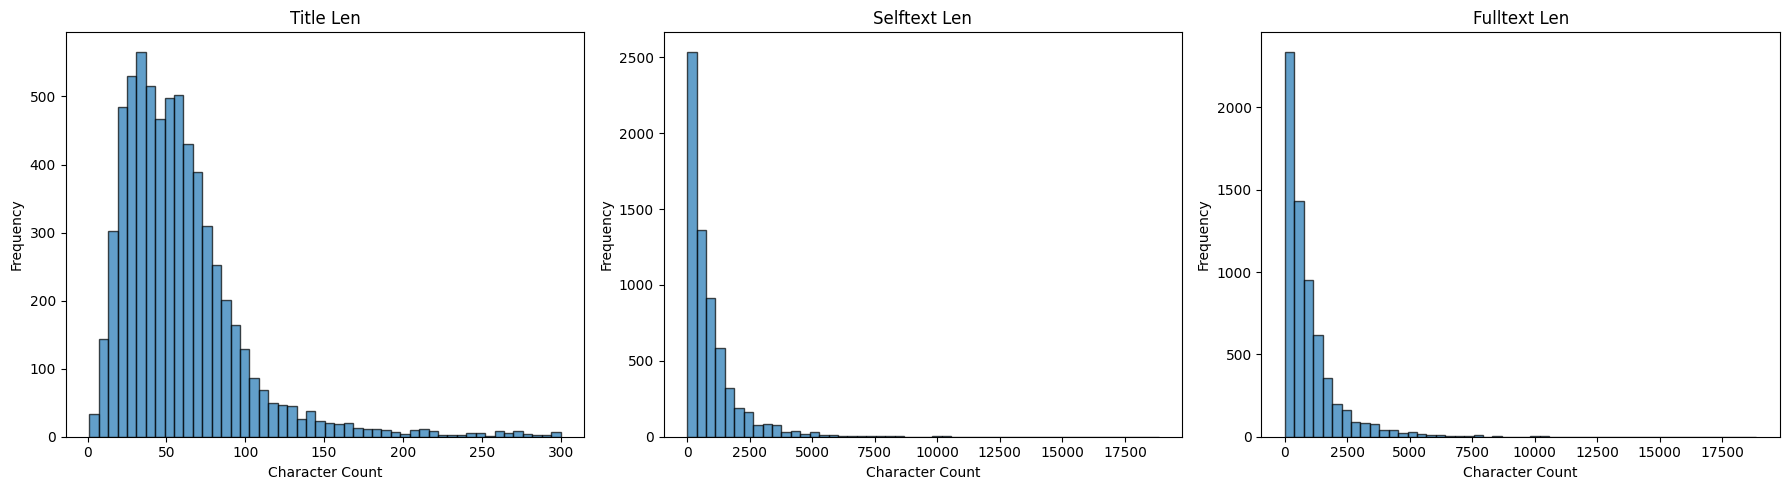

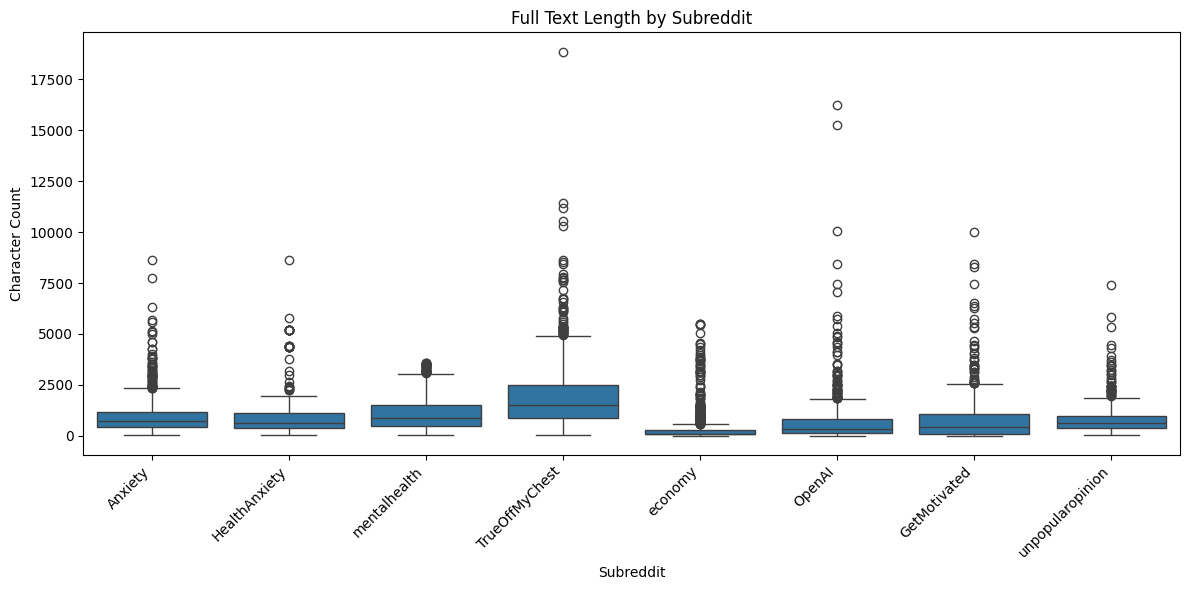

<Figure size 640x480 with 0 Axes>

In [38]:
# Analyze and visualize text length distributions across posts
analyze_text_lengths(posts_df)

# save the plots 
plt.savefig(ARTIFACTS / "../images/analyze_text_lengths.png", dpi=150)
plt.show()


---

## **4. Quality Check Summary**

**Key Findings:**

- **Posts:** 6,503 posts across 8 subreddits, reasonably balanced (4.6%-15.1% per subreddit)
- **Comments:** 13,422 comments with 79.7% post coverage (~2.1 comments per post)
- **Data quality:** No missing values in comments; only `removed_by_category` missing in posts (expected)
- **Text patterns:** Normal length distributions. Titles ~58 chars, posts ~950 chars total
- **Outliers:** Some very long posts visible in boxplot, may need attention in EDA

**Notable observations:**

- Dataset includes both mental health subreddits (Anxiety, HealthAnxiety, mentalhealth, TrueOffMyChest) and general subreddits (economy, OpenAI, GetMotivated, unpopularopinion)
- HealthAnxiety significantly smaller (300 posts vs 750-980 for others)
- Strong post-comment linkage (79.7% coverage)


[Next: Cleaning & Merge →](02_clean_merge.ipynb)